In [1]:
%matplotlib inline
import numpy as np
from skyfield.api import load
from scipy.optimize import newton
from matplotlib import pyplot as plt
import plotly
import plotly.plotly as py
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly.graph_objs import *
from footprint import *
init_notebook_mode(connected=True)
planets = load('de423.bsp')
plotly.tools.set_credentials_file(username='sevenlin123', api_key='vhjhhsCHepMx5oQGJPEp')

In [2]:
class plutino:
    """
    generate plutinos
    units: au, radius
    
    """
    def __init__(self, size = 1000, mjd = 57023, e_c = 0.175, e_sigma = 0.06, i_sigma = 12,\
                 amp_c = 75, amp_max = 155, amp_min = 0):
        self.size = size
        self.mjd = mjd
        self.lambda_N = None
        self.neptune_lambda()
        self.a = self.gen_a()
        self.e = self.gen_e(e_c, e_sigma)
        self.i = self.gen_i(i_sigma)
        self.amp = self.gen_amp(amp_c, amp_max, amp_min)
        self.phi = self.gen_phi(self.amp)
        self.M = self.gen_M()
        self.node = self.gen_node()
        self.arg = self.gen_arg()
        self.H = self.gen_H()
        cut = (self.e > 0) * (~np.isnan(self.i))
        self.a = self.a[cut]
        self.e = self.e[cut]
        self.i = self.i[cut]
        self.amp = self.amp[cut]
        self.phi = self.phi[cut]
        self.M = self.M[cut]
        self.node = self.node[cut]
        self.arg = self.arg[cut]
        self.H = self.H[cut]
        X, Y, Z, r = zip(*map(self.kep_to_xyz, self.a, self.e, self.i,\
                                                  self.arg, self.node, self.M)) # r**2 = X**2 + Y**2 + Z**2
        self.X = np.array(X)
        self.Y = np.array(Y)
        self.Z = np.array(Z)
        self.r = np.array(r)
        self.xyz_to_equa(self.X, self.Y, self.Z)
        self.H_to_mag()
        
    
    def gen_a(self):
        return 39.45 + np.random.random(self.size) * 0.4 - 0.2
        
    def gen_e(self, e_c, e_sigma):
        return np.random.normal(loc=e_c, scale=e_sigma, size = self.size)
        
    def gen_i(self, i_sigma):
        return np.arcsin(np.random.rayleigh(scale = i_sigma * np.pi/180., size = self.size))
        
    def gen_amp(self, amp_c, amp_max, amp_min):
        return np.random.triangular(amp_min, amp_c, amp_max, size = self.size) * np.pi / 180.
    
    def gen_phi(self, amp):
        return np.pi + amp * np.sin(2*np.pi*np.random.random(self.size)) 
        
    def gen_M(self):
        return 4*np.pi*np.random.random(self.size)
        
    def gen_node(self):
        return 2*np.pi*np.random.random(self.size) % (2*np.pi)
        
    def gen_arg(self):
        return (0.5*self.phi - 1.5*self.M - self.node + self.lambda_N) % (2*np.pi)
        
    def gen_H(self):
        alpha = 0.9
        h0 = 0
        h1 = 10
        h0s10 = 10**(alpha*h0)
        h1s10 = 10**(alpha*h1)
        return np.log10(np.random.random(self.size)*(h1s10-h0s10) + h0s10) / alpha
        
    def H_to_mag(self):
        phase = np.arccos((self.r**2 + self.delta**2 - self.earth_dis**2) / (2 * self.r * self.delta))
        phase_integral = 2/3. * ((1-phase/np.pi)*np.cos(phase) + 1/np.pi*np.sin(phase))
        self.mag_g = self.H + 2.5 * np.log10((self.r**2 * self.delta**2) / phase_integral)
        self.mag_r = self.mag_g - 0.5
        self.mag_i = self.mag_r - 0.5
        self.mag_z = self.mag_i - 0.5
        
    def neptune_lambda(self):
        neptune = planets[8]
        ts = load.timescale()
        t = ts.tai(jd=self.mjd+2400000.500428) #37 leap seconds        
        self.x_n, self.y_n, self.z_n = neptune.at(t).ecliptic_position().au
        self.lambda_N = np.arctan2(self.y_n, self.x_n) % (2*np.pi)

    def kep_to_xyz(self, a, e, i, arg, node, M):
        # compute eccentric anomaly
        f = lambda E, M, e: E - e * np.sin(E) - M
        E0 = M
        E = newton(f, E0, args=(M, e))
        # compute true anomaly
        v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
        # compute the barycentric distance
        r = a * (1 - e*np.cos(E))
        # compute X,Y,Z
        X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
        Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
        Z = r * (np.sin(i) * np.sin(arg + v))
        return X, Y, Z, r
        
    def xyz_to_equa(self, X0, Y0, Z0):
        earth = planets['earth']
        ts = load.timescale()
        t = ts.tai(jd=self.mjd+2400000.500428) #37 leap seconds
        epsilon =  23.43694 * np.pi/180.
        x_earth, y_earth, z_earth = earth.at(t).position.au
        self.earth_dis = (x_earth**2 + y_earth**2 + z_earth**2)**0.5
        X = X0 - x_earth
        Y = Y0 * np.cos(epsilon) - Z0 * np.sin(epsilon)  - y_earth
        Z = Y0 * np.sin(epsilon) + Z0 * np.cos(epsilon) - z_earth
        self.delta = (X**2 + Y**2+ Z**2)**0.5
        self.dec = np.arcsin(Z/(X**2+Y**2+Z**2)**0.5)
        self.ra = np.arctan2(Y, X) % (2*np.pi)

        

In [3]:
#p = plutino(size = 2000, mjd=58199, e_c = 0.3, e_sigma = 0.01, amp_c = 1, amp_max = 2, amp_min = 0)
p = plutino(size = 5000, mjd=57023)

(array([252., 245., 252., 263., 245., 238., 241., 250., 233., 285., 221.,
        256., 263., 236., 260., 255., 260., 239., 242., 261.]),
 array([39.25000983, 39.26998416, 39.2899585 , 39.30993284, 39.32990717,
        39.34988151, 39.36985584, 39.38983018, 39.40980451, 39.42977885,
        39.44975318, 39.46972752, 39.48970186, 39.50967619, 39.52965053,
        39.54962486, 39.5695992 , 39.58957353, 39.60954787, 39.62952221,
        39.64949654]),
 <a list of 20 Patch objects>)

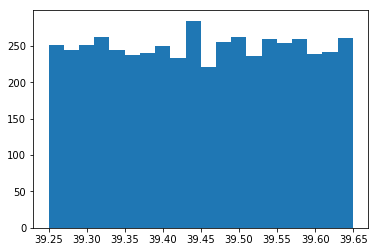

In [4]:
plt.hist(p.a, bins = 20)

(array([ 14.,  35.,  67., 140., 225., 334., 420., 577., 627., 655., 554.,
        505., 351., 221., 136.,  75.,  35.,  16.,   7.,   3.]),
 array([1.67026658e-04, 1.94565147e-02, 3.87460027e-02, 5.80354908e-02,
        7.73249788e-02, 9.66144668e-02, 1.15903955e-01, 1.35193443e-01,
        1.54482931e-01, 1.73772419e-01, 1.93061907e-01, 2.12351395e-01,
        2.31640883e-01, 2.50930371e-01, 2.70219859e-01, 2.89509347e-01,
        3.08798835e-01, 3.28088323e-01, 3.47377811e-01, 3.66667299e-01,
        3.85956787e-01]),
 <a list of 20 Patch objects>)

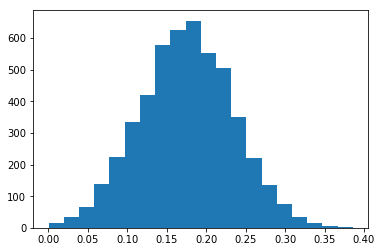

In [5]:
plt.hist(p.e, bins = 20)

(array([249., 593., 838., 813., 782., 599., 465., 294., 166.,  90.,  60.,
         24.,  14.,   3.,   3.,   1.,   2.,   0.,   0.,   1.]),
 array([ 0.23423394,  3.77227055,  7.31030716, 10.84834377, 14.38638038,
        17.92441699, 21.4624536 , 25.00049021, 28.53852682, 32.07656343,
        35.61460004, 39.15263665, 42.69067326, 46.22870987, 49.76674648,
        53.30478309, 56.8428197 , 60.38085631, 63.91889292, 67.45692953,
        70.99496614]),
 <a list of 20 Patch objects>)

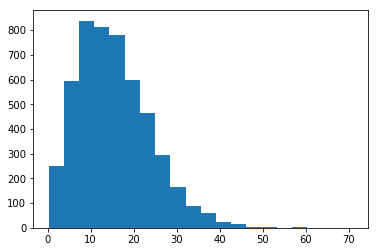

In [6]:
plt.hist(p.i*180/np.pi, bins = 20)

(array([2.000e+00, 0.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 9.000e+00,
        8.000e+00, 1.900e+01, 2.400e+01, 2.400e+01, 4.800e+01, 6.900e+01,
        1.100e+02, 1.580e+02, 2.340e+02, 3.120e+02, 4.720e+02, 7.520e+02,
        1.145e+03, 1.606e+03]),
 array([6.12521794, 6.31895367, 6.51268939, 6.70642511, 6.90016084,
        7.09389656, 7.28763229, 7.48136801, 7.67510373, 7.86883946,
        8.06257518, 8.25631091, 8.45004663, 8.64378235, 8.83751808,
        9.0312538 , 9.22498952, 9.41872525, 9.61246097, 9.8061967 ,
        9.99993242]),
 <a list of 20 Patch objects>)

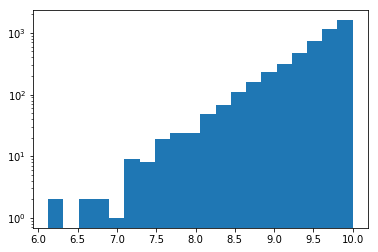

In [7]:
plt.yscale('log')
plt.hist(p.H, bins = 20)

(array([  1.,   1.,   1.,   4.,   6.,  16.,  26.,  38.,  77., 133., 261.,
        426., 580., 696., 762., 750., 672., 415., 123.,   9.]),
 array([21.69763971, 21.99978932, 22.30193893, 22.60408854, 22.90623815,
        23.20838776, 23.51053737, 23.81268697, 24.11483658, 24.41698619,
        24.7191358 , 25.02128541, 25.32343502, 25.62558463, 25.92773424,
        26.22988385, 26.53203346, 26.83418307, 27.13633268, 27.43848229,
        27.7406319 ]),
 <a list of 20 Patch objects>)

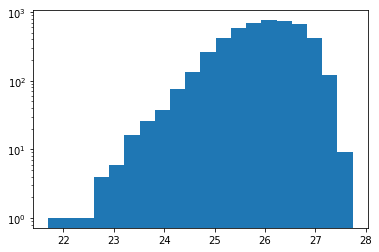

In [8]:
plt.yscale('log')
plt.hist(p.mag_g, bins = 20)

(array([230., 249., 247., 253., 272., 248., 241., 232., 237., 251., 279.,
        258., 225., 263., 233., 274., 241., 224., 275., 265.]),
 array([6.45729949e-04, 6.28818381e-01, 1.25699103e+00, 1.88516368e+00,
        2.51333633e+00, 3.14150899e+00, 3.76968164e+00, 4.39785429e+00,
        5.02602694e+00, 5.65419959e+00, 6.28237224e+00, 6.91054489e+00,
        7.53871754e+00, 8.16689019e+00, 8.79506285e+00, 9.42323550e+00,
        1.00514081e+01, 1.06795808e+01, 1.13077534e+01, 1.19359261e+01,
        1.25640988e+01]),
 <a list of 20 Patch objects>)

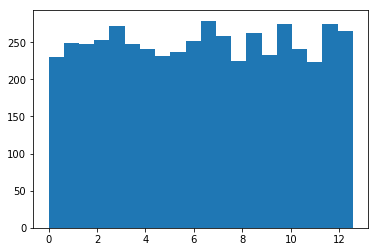

In [9]:
plt.hist(p.M, bins = 20)

(array([264., 264., 246., 238., 209., 262., 232., 259., 276., 275., 222.,
        240., 247., 247., 264., 253., 263., 251., 266., 219.]),
 array([1.17433786e-03, 3.15230919e-01, 6.29287500e-01, 9.43344081e-01,
        1.25740066e+00, 1.57145724e+00, 1.88551382e+00, 2.19957041e+00,
        2.51362699e+00, 2.82768357e+00, 3.14174015e+00, 3.45579673e+00,
        3.76985331e+00, 4.08390989e+00, 4.39796647e+00, 4.71202305e+00,
        5.02607963e+00, 5.34013622e+00, 5.65419280e+00, 5.96824938e+00,
        6.28230596e+00]),
 <a list of 20 Patch objects>)

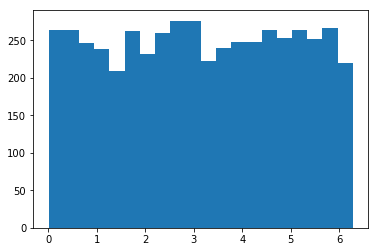

In [10]:
plt.hist(p.arg, bins = 20)

(array([219., 274., 285., 240., 265., 253., 245., 267., 246., 231., 237.,
        266., 227., 261., 237., 259., 241., 288., 225., 231.]),
 array([4.11657811e-04, 3.14479736e-01, 6.28547814e-01, 9.42615893e-01,
        1.25668397e+00, 1.57075205e+00, 1.88482013e+00, 2.19888821e+00,
        2.51295628e+00, 2.82702436e+00, 3.14109244e+00, 3.45516052e+00,
        3.76922860e+00, 4.08329668e+00, 4.39736475e+00, 4.71143283e+00,
        5.02550091e+00, 5.33956899e+00, 5.65363707e+00, 5.96770515e+00,
        6.28177322e+00]),
 <a list of 20 Patch objects>)

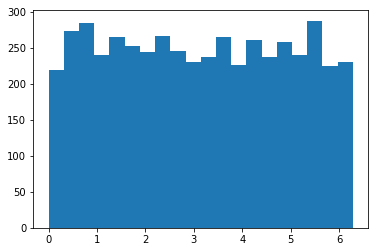

In [11]:
plt.hist(p.node, bins = 20)

(array([272., 255., 210., 239., 254., 272., 253., 252., 223., 259., 263.,
        261., 241., 260., 250., 230., 250., 271., 243., 239.]),
 array([2.03310252e-03, 3.15992062e-01, 6.29951022e-01, 9.43909981e-01,
        1.25786894e+00, 1.57182790e+00, 1.88578686e+00, 2.19974582e+00,
        2.51370478e+00, 2.82766374e+00, 3.14162270e+00, 3.45558166e+00,
        3.76954062e+00, 4.08349958e+00, 4.39745854e+00, 4.71141750e+00,
        5.02537646e+00, 5.33933542e+00, 5.65329437e+00, 5.96725333e+00,
        6.28121229e+00]),
 <a list of 20 Patch objects>)

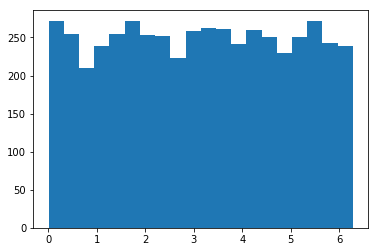

In [12]:
plt.hist((p.arg+p.node) % (2*np.pi), bins = 20)

(array([ 18.,  49., 102., 177., 234., 344., 364., 367., 409., 445., 399.,
        400., 393., 366., 327., 236., 181., 108.,  56.,  22.]),
 array([0.55162397, 0.81062157, 1.06961917, 1.32861677, 1.58761436,
        1.84661196, 2.10560956, 2.36460715, 2.62360475, 2.88260235,
        3.14159995, 3.40059754, 3.65959514, 3.91859274, 4.17759034,
        4.43658793, 4.69558553, 4.95458313, 5.21358072, 5.47257832,
        5.73157592]),
 <a list of 20 Patch objects>)

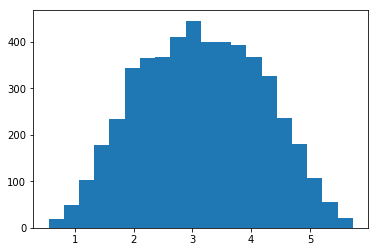

In [13]:
plt.hist(p.phi, bins = 20)

In [14]:
def kep_to_xyz(a, e, i, arg, node, M):
    # compute eccentric anomaly
    f = lambda E, M, e: E - e * np.sin(E) - M
    E0 = M
    E = newton(f, E0, args=(M, e))
    # compute true anomaly
    v = 2 * np.arctan2((1 + e)**0.5*np.sin(E/2.), (1 - e)**0.5*np.cos(E/2.))
    # compute the radius
    r = a * (1 - e*np.cos(E))
    # compute X,Y,Z
    X = r * (np.cos(node) * np.cos(arg + v) - np.sin(node) * np.sin(arg + v) * np.cos(i))
    Y = r * (np.sin(node) * np.cos(arg + v) + np.cos(node) * np.sin(arg + v) * np.cos(i))
    Z = r * (np.sin(i) * np.sin(arg + v))
    return X, Y, Z

In [15]:
xn, yn, zn = zip(*map(kep_to_xyz, 30+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))
x45, y45, z45 = zip(*map(kep_to_xyz, 45+np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.zeros(1000), np.arange(0, 6.28, 0.00628)))

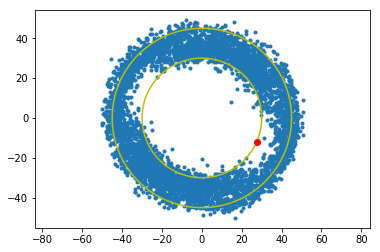

In [16]:
plt.axis('equal')
plt.scatter(p.X,p.Y, marker = '.')
plt.plot(xn, yn, 'y')
plt.plot(x45, y45, 'y')
plt.plot(p.x_n, p.y_n, 'ro')

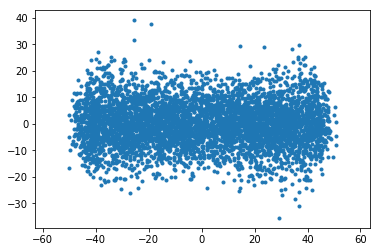

In [17]:
plt.axis('equal')
plt.scatter(p.X,p.Z, marker = '.')

In [22]:
def buildmap(ecliptic_plots=True):
    lon, lat = define_footprint(ecliptic_plots=ecliptic_plots) 
#    lon2, lat2 = define_footprint(polydef='poly_bliss_p9.txt', ecliptic_plots=ecliptic_plots) 
    m = Basemap(lon_0=0, projection='moll', celestial=True)
    x, y = m( lon, lat )
#    x2,y2 = m(lon2, lat2)
    xy = zip(x,y)
#    xy2 = zip(x2,y2)
    foot = patches.Polygon( xy, facecolor='cornflowerblue', edgecolor=None, alpha=0.4 )
#    foot2 = patches.Polygon( xy2, facecolor='lightpink', edgecolor=None, alpha=0.4 )
    plt.gca().add_patch(foot)
#    plt.gca().add_patch(foot2)
    fields = SNfields()
    for f in fields:
        if ecliptic_plots:
            ecl = ephem.Ecliptic(ephem.Equatorial(f.a_ra, f.a_dec))
            lon = ecl.lon if ecl.lon<ephem.degrees('180') else ecl.lon-2*np.pi    
            m.tissot(lon*180/np.pi, ecl.lat*180/np.pi, 1.05, 100, facecolor='g', alpha=0.5)
        else:
            ra = f.a_ra if f.a_ra<ephem.degrees('180') else f.a_ra-2*np.pi
            m.tissot(ra*180/np.pi, f.a_dec*180/np.pi, 1.05, 100, facecolor='r', alpha=0.5)
    ra = p.ra*180/np.pi
    dec = p.dec*180/np.pi
    for i in range(len(ra)):
        m.scatter(ra[i],dec[i],3,marker='.',color='k', latlon=True)
    m.drawmapboundary()
    parallels = np.arange(-180.,181,20.)
    m.drawparallels(parallels,labels=[False,True,True,False], alpha=0.4)
    meridians = np.arange(-180.,181.,20.)
    m.drawmeridians(meridians, alpha=0.4)
    return m

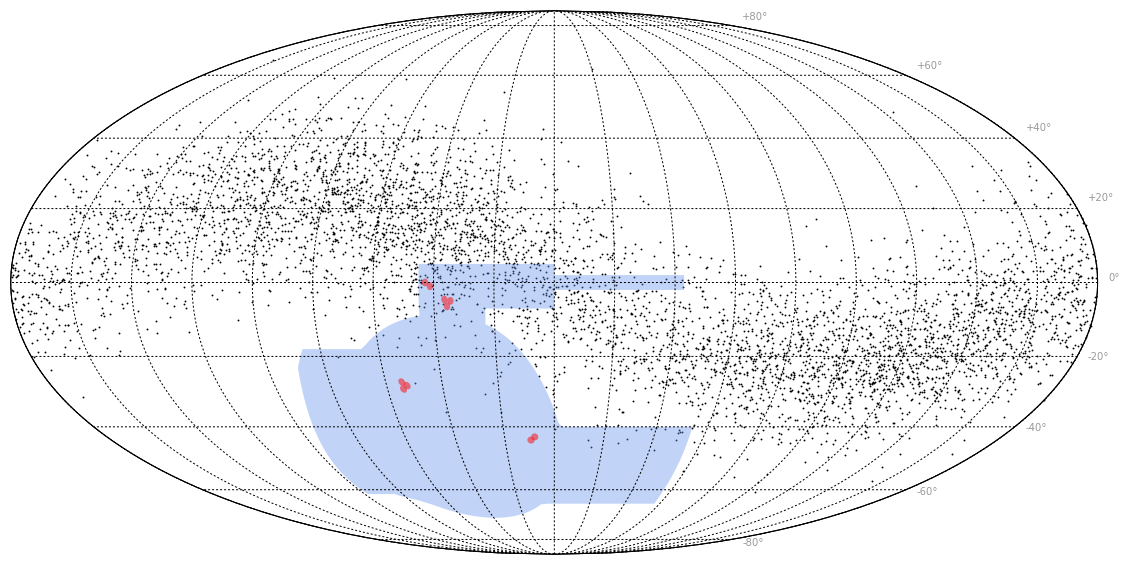

In [23]:
plt.figure(figsize=(20,10))
m = buildmap(ecliptic_plots=False)

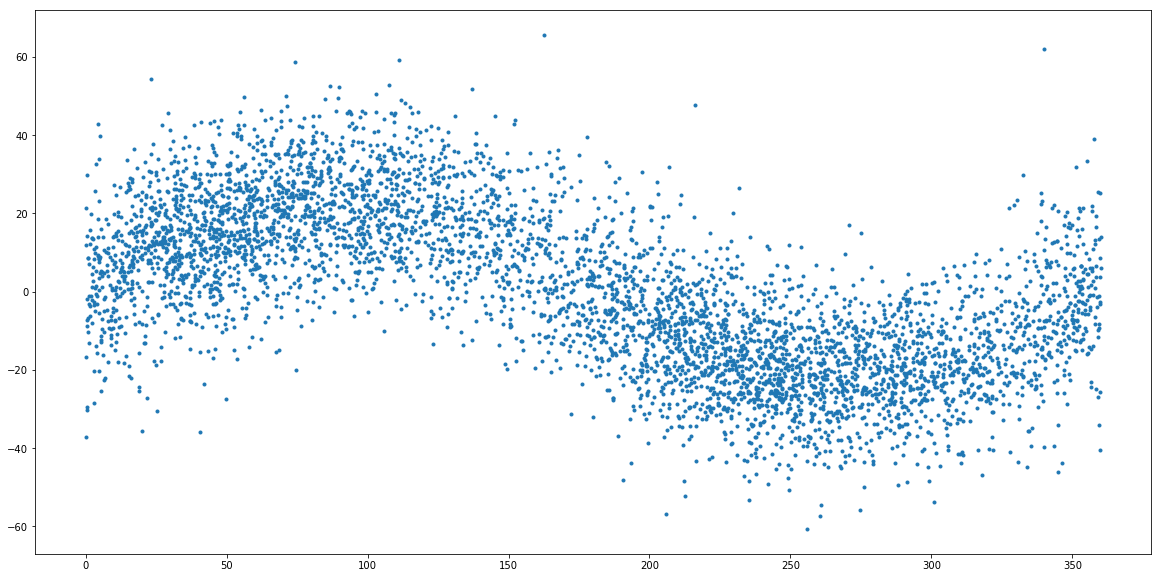

In [20]:
plt.figure(figsize=(20,10))
plt.scatter(p.ra*180/np.pi,p.dec*180/np.pi, marker = '.')

In [21]:
plutinos = Scatter3d(x=p.X, y=p.Y, z=p.Z, mode='markers', marker=dict(size=1, symbol='circle'), opacity=0.7, name='plutinos')
sun = Scatter3d(x=0, y=0, z=0, mode='markers', marker=dict(size=10, symbol='circle'), opacity=1, name='Sun')
neptune = Scatter3d(x=p.x_n, y=p.y_n, z=p.z_n, mode='markers', marker=dict(size=5, symbol='circle'), opacity=0.7, name ='Neptune')
fig = Figure(data=[plutinos, sun, neptune])
py.iplot(fig)